In [1]:
import numpy as np
import scipy.ndimage as sn
import scipy.signal as ss
import matplotlib.pyplot as plt
from skimage.io import imsave
from skimage import morphology as mp
from skimage import transform
import math
from skimage.color import rgb2hsv, hsv2rgb
from skimage.util import random_noise as rn
from PIL.Image import open as imread
from PIL import ImageOps as Iops
import time

In [2]:
def showG(im, boundaries = True):
    if np.average(im) < 1:
        im = im*255
    if boundaries:
        plt.imshow(im, cmap='gray', vmin=0, vmax=255)
    else:    
        plt.imshow(im, cmap='gray')
    return plt.show()

def showC(im):
    plt.imshow(im, vmin=0, vmax=255)
    return plt.show()

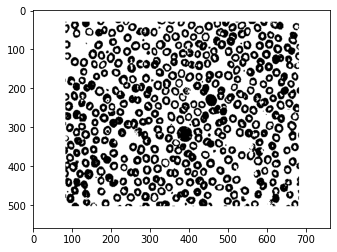

In [4]:
im1 = imread('cells_binary.png')
g1 = Iops.grayscale(im1)
A1 = np.array(g1)
showG(A1)

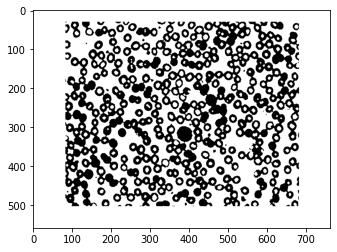

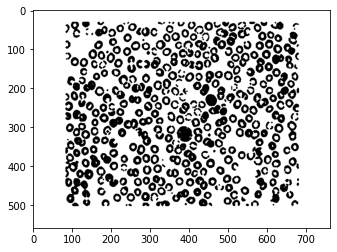

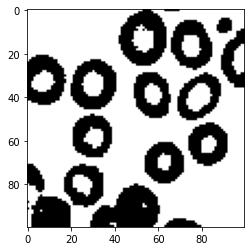

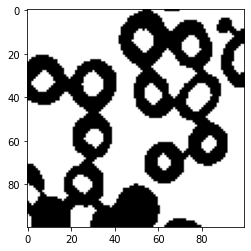

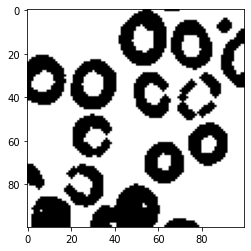

In [5]:
# Opening - erosian then dilation
disc = mp.disk(2)

# The morphological opening on an image is defined as an erosion followed by a dilation.
# Opening can remove small bright spots (i.e. “salt”) and connect small dark cracks. 
# This tends to “open” up (dark) gaps between (bright) features.
# https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.opening
res = mp.opening(A1, disc)
showG(res)

# The morphological closing on an image is defined as a dilation followed by an erosion. 
# Closing can remove small dark spots (i.e. “pepper”) and connect small bright cracks. 
# This tends to “close” up (dark) gaps between (bright) features.
# https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.closing
res = mp.closing(A1, disc)
showG(res)


res = A1[100:200,100:200]
showG(res)
res = mp.opening(A1, disc)[100:200,100:200]
showG(res)
res = mp.closing(A1, disc)[100:200,100:200]
showG(res)

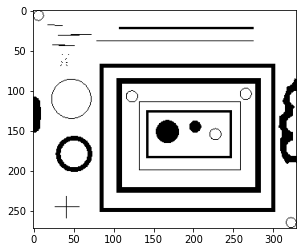

In [6]:
im2 = imread('blobs_inv.png')
g2 = Iops.grayscale(im2)
A2 = np.array(g2)
A2[A2 == 255] = 1
showG(A2)

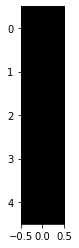

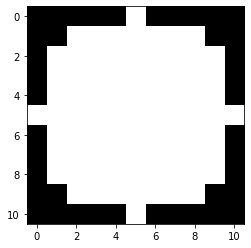

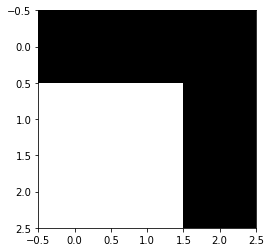

In [7]:
se1 = np.array([[1],
                [1],
                [1],
                [1],
                [1]])
se2 = mp.disk(5)
se3 = np.array([[0,0,0],
                [1,1,0],
                [1,1,0]])
showG(se1)
showG(se2)
showG(se3)

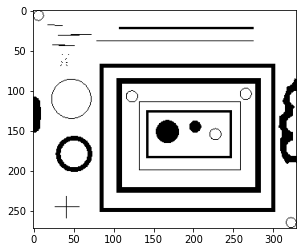

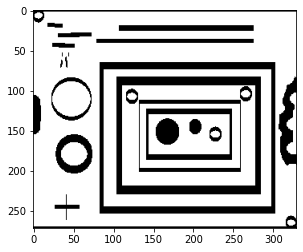

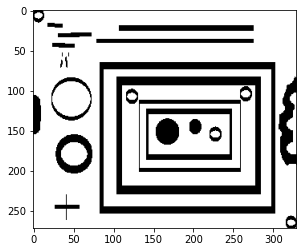

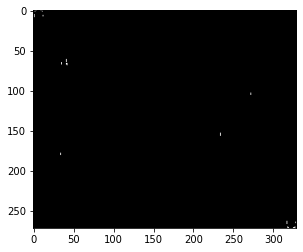

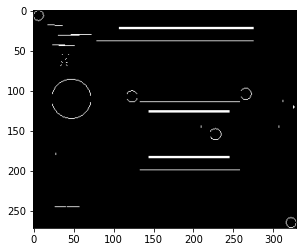

In [8]:
showG(A2)

# Ask question about flipping the image on thursday since we do it to make the black edges the foreground.
def hit_miss(im, se):
    e = mp.binary_erosion
    f = im #f = 1-im # flip image to set white as background 
    
    A = e(f, se)
    B = e(1-f, 1-se)
    return A*B

res = sn.morphology.binary_hit_or_miss(A2, se1)
showG(res)

res = hit_miss(A2, se1)
showG(res)

res = mp.white_tophat(A2, se1)
showG(res)

res = mp.black_tophat(A2, se1)
showG(res)

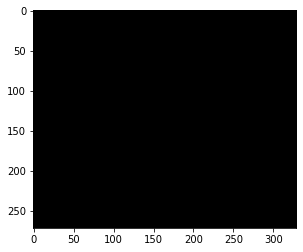

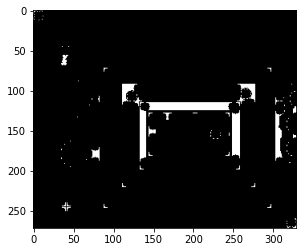

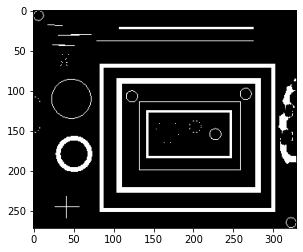

In [9]:
res = hit_miss(A2, se2)
showG(res)

res = mp.white_tophat(A2, se2)
showG(res)

res = mp.black_tophat(A2, se2)
showG(res)

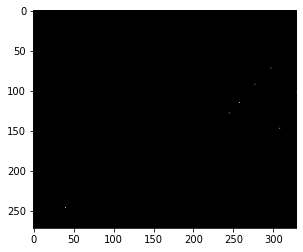

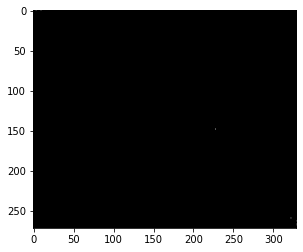

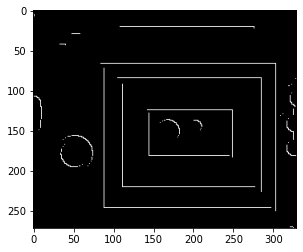

In [10]:
res = hit_miss(A2, se3)
showG(res)

res = mp.white_tophat(A2, se3)
showG(res)

res = mp.black_tophat(A2, se3)
showG(res)

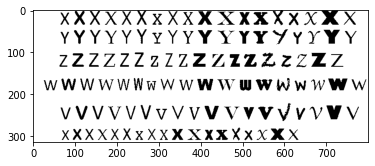

In [11]:
im3 = imread('digits_binary_inv.png')
#g3 = Iops.grayscale(im3)
A3 = np.round(np.array(im3) / np.max(np.array(im3))).astype(np.int)
showG(A3)

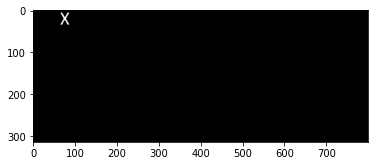

In [125]:
def getX(pad = 0, im = A3):
    return 1-np.pad(1-im[6:35,66:86], pad)

x = getX()
showG(mp.binary_dilation(hit_miss(A3, x), 1-x))


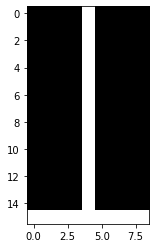

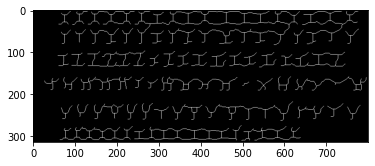

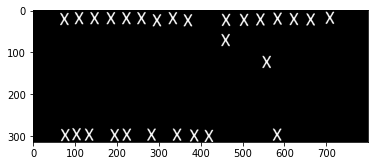

28 matches


In [126]:
se = mp.square(9)

modIm = 1-A3
modIm = mp.binary_closing(modIm, se)
modIm = mp.skeletonize(modIm)
    
for _ in range(5):
    modIm = mp.binary_dilation(modIm, se)
    modIm = mp.skeletonize(modIm)

x = getX(pad = 0, im = modIm)
modX = x[7:-6, 5:-6]
showG(modX)

showG(modIm)

res = hit_miss(modIm, modX)
showG(mp.binary_dilation(res, 1-getX()))
print(np.sum(res), 'matches')

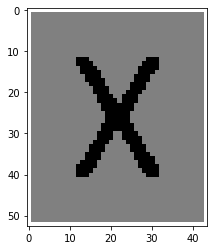

NameError: name 'cv2' is not defined

In [127]:
x = getX(pad = 12)
#x = mp.skeletonize(1-x)
x = np.array((1-x), dtype='uint8')
#print(x)
modx = np.copy(x)
modx = np.where(modx == 0, -1, 1)
#print(modx)
modx = np.where(modx == 1, -1, 0)
#modx = np.where(modx == -1, 1, 0)
modx[:,0:5] = 0
modx[:,-5:] = 0
modx[0:5,:] = 0
modx[-5:,:] = 0
modx[:,0:1] = 1
modx[:,-1:] = 1
modx[0:1,:] = 1
modx[-1:,:] = 1
plt.imshow(modx,cmap='gray')
plt.show()

out = cv2.morphologyEx(A3, cv2.MORPH_HITMISS, modx)
showG(out)

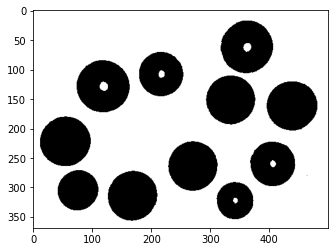

In [ ]:
im4 = imread('money_bin.jpg')
g4 = Iops.grayscale(im4)
A4 = np.array(g4)
A4 = np.round(np.array(im4) / np.max(np.array(im4))).astype(np.int)
showG(A4)

In [128]:
def count_regions(mod, radius, foreground = 1):
    mod = np.array(mod)
    x_max = mod.shape[0]
    y_max = mod.shape[1]
    s = 0
    blobs = np.argwhere(mod == foreground)
    while len(blobs) > 0:
        x,y = blobs[0]
        mod[max(0,x-radius):min(x+radius, x_max),max(0,y-radius):min(y+radius, y_max)] = 0
        s += 1
        blobs = np.argwhere(mod == foreground)
    return s

In [129]:
m05 = np.full((80,80),0)
start, stop = 30,50
m05[start:stop,start:stop] = -1
m05[start+1:stop-1,start+1:stop-1] = 0
m05[39:40,39:40] = -1
m05 = np.pad(m05,1,'constant',constant_values=1)

m1 = np.full((70,70),0)
start, stop = 25,45
m1[start:stop,start:stop] = -1
m1[start+1:stop-1,start+1:stop-1] = 0
m1[34:35,34:35] = 1
m1 = np.pad(m1,1,'constant',constant_values=1)

m2 = np.full((80,80),0)
start, stop = 30,50
m2[start:stop,start:stop] = -1
m2[start+1:stop-1,start+1:stop-1] = 0
m2[39:40,39:40] = 1
m2 = np.pad(m2,1,'constant',constant_values=1)

m5 = np.full((90,90),0)
start, stop = 15,75
m5[start:stop,start:stop] = -1
m5[start+1:stop-1,start+1:stop-1] = 0
m5[44:45,44:45] = 1
m5 = np.pad(m5,1,'constant',constant_values=1)

m20 = np.full((90,90),0)
start, stop = 20,70
m20[start:stop,start:stop] = -1
m20[start+1:stop-1,start+1:stop-1] = 0
m20[44:45,44:45] = -1
m20 = np.pad(m20,1,'constant',constant_values=1)

def count_coins(im):
    s = 0
    masks = [m05,m1,m2,m5,m20]
    values = [0.5,1,2,5,20]
    mask_values = zip(masks,values)
    
    for m,v in mask_values:
        out = cv2.morphologyEx(A4, cv2.MORPH_HITMISS, m)
        n = count_regions(out, 20)
        s += n*v
    return s

In [3]:
diatoms_train = np.loadtxt('SIPdiatomsTrain.txt', delimiter = ',').reshape(-1,90,2)
diatoms_train -= diatoms_train.mean(axis=1).reshape(-1,1,2) # Centering all diatoms around 0
diatoms_test = np.loadtxt('SIPdiatomsTest.txt', delimiter = ',').reshape(-1,90,2)

In [4]:
diatom = diatoms_train[0]

In [5]:
def plt_diatom(diatom, diatom_b = None):
    diatomX = diatom[:,0]
    diatomY = diatom[:,1]
    plt.figure(figsize=(5,5))
    plt.plot(diatomX, diatomY,c = 'blue', label='Target')
    plt.plot([diatomX[0],diatomX[-1]], [diatomY[0],diatomY[-1]], c = 'blue')
    plt.xlim([30, -30])
    plt.ylim([30, -30])
    if diatom_b is not None:
        diatomX = diatom_b[:,0]
        diatomY = diatom_b[:,1]
        plt.plot(diatomX, diatomY,c = 'orange', label='Original')
        plt.plot([diatomX[0],diatomX[-1]], [diatomY[0],diatomY[-1]], c = 'orange')
        plt.legend()
    return plt.show()

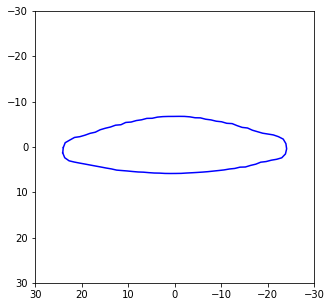

In [6]:
plt_diatom(diatom)

In [7]:
def procrustes(diatom_a, diatom_b):
    def sum_vecs(vecs_a, vecs_b):
        s = 0
        for y, x in zip(vecs_b, vecs_a):
            s += y.T@x
        return s

    yx = diatom_a.T @ diatom_b
    u, s, v = np.linalg.svd(yx)
    R = v @ u

    b = diatom_b@R

    s = sum_vecs(diatom_a, b)/sum_vecs(b, b)
    scale_matrix = np.identity(2)*s

    return b@scale_matrix

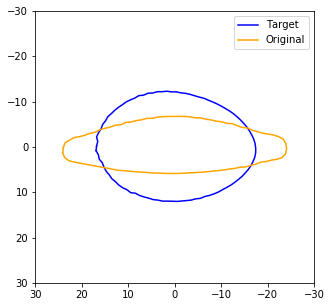

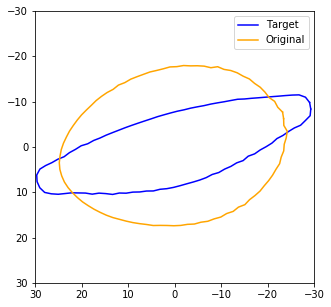

In [8]:
b = 36
plt_diatom(procrustes(diatom, diatoms_train[b]), diatom)
plt_diatom(procrustes(diatoms_train[b], diatom), diatoms_train[b])

In [9]:
def align_data_sets(target_set, target):
    nset = []
    for sub_target in target_set:
        nset.append(procrustes(target, sub_target))
    return np.array(nset)

In [10]:
train = align_data_sets(diatoms_train, diatom)
test = align_data_sets(diatoms_test, diatom)

In [11]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
XTrain = np.loadtxt('SIPdiatomsTrain.txt',delimiter=',')
XTest = np.loadtxt('SIPdiatomsTest.txt',delimiter=',')
XTrainL = np.loadtxt('SIPdiatomsTrain_classes.txt',delimiter=',')
XTestL = np.loadtxt('SIPdiatomsTest_classes.txt',delimiter=',')

knn = KNeighborsClassifier()
knn.fit(XTrain, XTrainL)

Pred_labels = knn.predict(XTest)
acc = sum(Pred_labels==XTestL) / len(XTestL)
print(acc)

0.03214285714285714


In [12]:
knn = KNeighborsClassifier()
knn.fit(train.reshape(-1,180), XTrainL)

Pred_labels = knn.predict(test.reshape(-1,180))
acc = sum(Pred_labels==XTestL.T) / len(XTestL)
print(acc)

0.17857142857142858


In [ ]:
#3.1
I_tilde(x,y) = np.identity(2) * [x,y].T + [t_x,t_y].T

#3.2
[[1,0,t_x],   [[x],
 [0,1,t_y], *  [y],
 [0,0, 1 ]]    [1]]

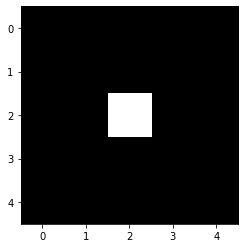

In [ ]:
whiteDot = np.array([[0,0,0,0,0],
                     [0,0,0,0,0],
                     [0,0,1,0,0],
                     [0,0,0,0,0],
                     [0,0,0,0,0]])
showG(whiteDot)

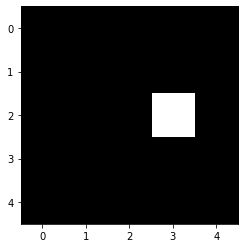

In [ ]:
from skimage.morphology import binary_dilation as bd
mask = [[0,0,0],
        [0,0,1],
        [0,0,0]]
showG(bd(whiteDot, mask))

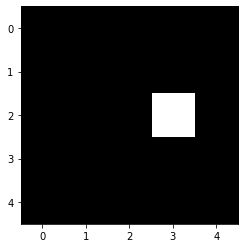

In [ ]:
import scipy
res = scipy.signal.convolve2d(whiteDot, mask, mode='same')
showG(res)

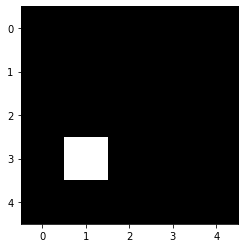

In [ ]:
def shiftKernel(im, a, b):
    n = 2*max(abs(a),abs(b))+1
    k = np.full((n,n), 0)
    k[-b+n//2,a+n//2] = 1
    return scipy.signal.convolve2d(im, k, mode='same')
showG(shiftKernel(whiteDot,-1,-1))

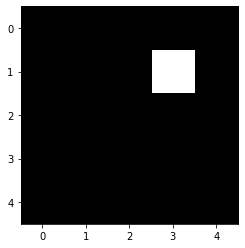

In [ ]:
def homoTransform(im, tx, ty):
    c = np.full_like(im, 0)
    H = np.array([[1,0,tx],
                  [0,1,-ty],
                  [0,0,1 ]])
    for y in range(im.shape[0]-1):
        for x in range(im.shape[1]-1):
            v = np.array([[x],
                          [y],
                          [1]])
            nv = np.dot(H,v)
            nx = int(np.round(nv[0]))
            ny = int(np.round(nv[1]))
            if(nx < 0 or nx > (im.shape[1]-1) or ny < 0 or ny > (im.shape[0]-1)):
                continue
            c[ny,nx] = im[y,x] 
    return c
showG(homoTransform(whiteDot,0.6,1.2))

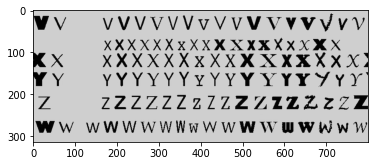

0.8098605109760803


In [ ]:
#f(x-a, y-b) = exp(-i(ua + vb))F(u,v)

from scipy.fft import fft2, ifft2, fftshift, ifftshift

def fourier_shift(im, a, b):
    n1 = im.shape[0]
    n2 = im.shape[1]
    u,v = np.mgrid[0:n1,0:n2]
    k = np.exp(-2j*np.pi*(u*b/n1 + v*a/n2))

    k = fftshift(k)

    fft = fft2(im)
    filtered = fft * k
    return np.absolute(np.real(ifft2(filtered)))

res = fourier_shift(A3, 100.9, 100.9)
plt.imshow(res,cmap='gray',vmin=0,vmax=1)
plt.show()
print(res[2,3])


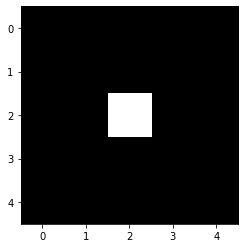

In [ ]:
fft = fft2(whiteDot)
for y in range(fft.shape[0]-1):
    for x in range(fft.shape[1]-1):
        fft[y,x] = fft[y,x] * np.exp(-2j*np.pi)
res = ifft2(fft)
showG(np.real(res))

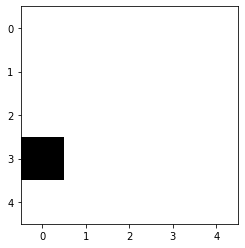

In [ ]:
mask = np.array([[0,0,0,0,0],
                 [0,0,0,1,0],
                 [0,0,0,0,0],
                 [0,0,0,0,0],
                 [0,0,0,0,0]])
fft_mask = fft2(mask)
fft_im = fft2(whiteDot)
shifted_mask = fftshift(fft_mask)
filtered = fft_im * shifted_mask
res = ifft2(filtered)
plt.imshow(np.real(res),cmap='gray')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=67a9cf59-e096-4e40-b279-af03ae49778f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>